<h1>Using R with Amazon SageMaker</h1>

This sample Notebook describes how to train, deploy, and retrieve predictions from a machine learning (ML) model using [Amazon SageMaker](https://aws.amazon.com/sagemaker/) and [R](https://www.r-project.org/). The model predicts abalone age as measured by the number of rings in the shell. The [reticulate](https://rstudio.github.io/reticulate/) package will be used as an R interface to [Amazon SageMaker Python SDK](https://sagemaker.readthedocs.io/en/latest/index.html) to make API calls to Amazon SageMaker. The `reticulate` package translates between R and Python objects, and Amazon SageMaker provides a serverless data science environment to train and deploy ML models at scale.


<h3>Reticulating the Amazon SageMaker Python SDK</h3>

First, load the `reticulate` library and import the `sagemaker` Python module. Once the module is loaded, use the `$` notation in R instead of the `.` notation in Python to use available classes. 

In [6]:
library(reticulate)
sagemaker <- import('sagemaker')

<h3>Creating and accessing the data storage</h3>

The `Session` class provides operations for working with the following [boto3](https://boto3.amazonaws.com/v1/documentation/api/latest/index.html) resources with Amazon SageMaker:

* [S3](https://boto3.readthedocs.io/en/latest/reference/services/s3.html)
* [SageMaker](https://boto3.readthedocs.io/en/latest/reference/services/sagemaker.html)
* [SageMakerRuntime](https://boto3.readthedocs.io/en/latest/reference/services/sagemaker-runtime.html)

Let's create an [Amazon Simple Storage Service](https://aws.amazon.com/s3/) bucket for your data. 

In [7]:
session <- sagemaker$Session()
bucket <- session$default_bucket()
prefix <- 'native-r-byo'

**Note** - The `default_bucket` function creates a unique Amazon S3 bucket with the following name: 

`sagemaker-<aws-region-name>-<aws account number>`

Specify the IAM role's [ARN](https://docs.aws.amazon.com/general/latest/gr/aws-arns-and-namespaces.html) to allow Amazon SageMaker to access the Amazon S3 bucket. You can use the same IAM role used to create this Notebook:

In [8]:
role_arn <- sagemaker$get_execution_role()

<h3>Downloading and processing the dataset</h3>

The model uses the [abalone dataset](https://archive.ics.uci.edu/ml/datasets/abalone) from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/index.php). First, download the data and start the [exploratory data analysis](https://en.wikipedia.org/wiki/Exploratory_data_analysis). Use tidyverse packages to read the data, plot the data, and transform the data into ML format for Amazon SageMaker:

In [9]:
library(readr)
data_file <- 'iris.csv'
iris <- read_csv(file = data_file, col_names = TRUE)
head(iris)

Parsed with column specification:
cols(
  Sepal.Length = col_double(),
  Sepal.Width = col_double(),
  Petal.Length = col_double(),
  Petal.Width = col_double(),
  Species = col_character()
)


Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
5.1,3.5,1.4,0.2,setosa
4.9,3.0,1.4,0.2,setosa
4.7,3.2,1.3,0.2,setosa
4.6,3.1,1.5,0.2,setosa
5.0,3.6,1.4,0.2,setosa
5.4,3.9,1.7,0.4,setosa


Visually explore the distribution of Sepal Length

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang


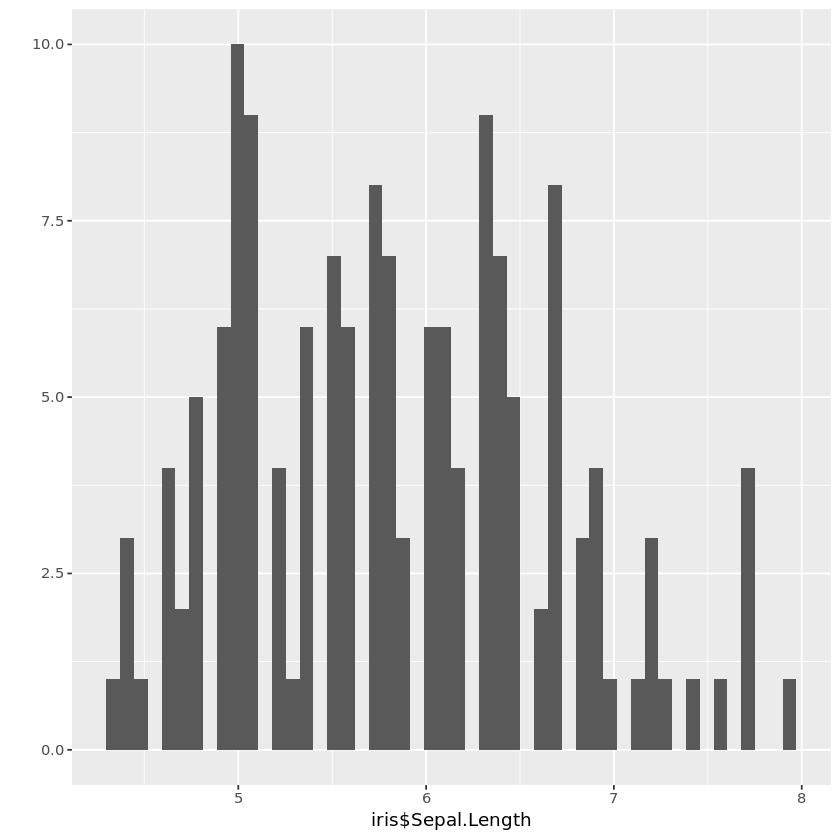

In [10]:
library(ggplot2)
qplot(iris$Sepal.Length, geom='histogram', bins=50)

---
## Data
For this illustrative example, we'll simply use `iris`.  This a classic, but small, dataset used to test supervised learning algorithms.  Typically the goal is to predict one of three flower species based on various measurements of the flowers' attributes.  Further detail can be found [here](https://en.wikipedia.org/wiki/Iris_flower_data_set).

Then let's copy the data to S3.

In [11]:
s3_train <- session$upload_data(path = 'iris.csv', 
                                bucket = bucket, 
                                key_prefix = paste0(prefix, '/train'))

In [12]:
s3_train_input <- sagemaker$s3_input(s3_data = s3_train, 
                                     content_type = 'csv')

_Note: Although we could, we'll avoid doing any preliminary transformations on the data, instead choosing to do those transformations inside the container.  This is not typically the best practice for model efficiency, but provides some benefits in terms of flexibility._

<h3>Training the model</h3>

Amazon SageMaker algorithm are available via a [Docker](https://www.docker.com/) container. To train an [XGBoost](https://en.wikipedia.org/wiki/Xgboost) model, specify the training containers in [Amazon Elastic Container Registry](https://aws.amazon.com/ecr/) (Amazon ECR) for the AWS Region.

In [13]:
boto3 <- import('boto3')
account = boto3$client('sts')$get_caller_identity()$Account
container = sprintf('%s.dkr.ecr.%s.amazonaws.com/sagemaker-rmars:latest', account, session$boto_region_name)

Define an Amazon SageMaker [Estimator](http://sagemaker.readthedocs.io/en/latest/estimators.html), which can train any supplied algorithm that has been containerized with Docker. When creating the Estimator, use the following arguments:
* **image_name** - The container image to use for training
* **role** - The Amazon SageMaker service role
* **train_instance_count** - The number of Amazon EC2 instances to use for training
* **train_instance_type** - The type of Amazon EC2 instance to use for training
* **train_volume_size** - The size in GB of the [Amazon Elastic Block Store](https://aws.amazon.com/ebs/) (Amazon EBS) volume to use for storing input data during training
* **train_max_run** - The timeout in seconds for training
* **input_mode** - The input mode that the algorithm supports
* **output_path** - The Amazon S3 location for saving the training results (model artifacts and output files)
* **output_kms_key** - The [AWS Key Management Service](https://aws.amazon.com/kms/) (AWS KMS) key for encrypting the training output
* **base_job_name** - The prefix for the name of the training job
* **sagemaker_session** - The Session object that manages interactions with Amazon SageMaker API
* **train_max_run** - The maximum timeout in seconds

In [14]:
s3_output <- paste0('s3://', bucket, '/', prefix, '/output')
estimator <- sagemaker$estimator$Estimator(image_name = container,
                                           role = role_arn,
                                           train_instance_count = 1L,
                                           train_instance_type = 'ml.m5.large',
                                           train_volume_size = 30L,
                                           train_max_run = 3600L,
                                           input_mode = 'File',
                                           output_path = s3_output,
                                           output_kms_key = NULL,
                                           base_job_name = NULL,
                                           sagemaker_session = NULL,
                                           train_max_run = 3600L)

**Note** - The equivalent to `None` in Python is `NULL` in R.

Specify the R-mars hyperparameters and fit the model. Set the number of rounds for training to 100 which is the default value when using the XGBoost library outside of Amazon SageMaker. Also specify the input data and a job name based on the current time stamp:

In [15]:
estimator$set_hyperparameters(target = 'Sepal.Length')
estimator$set_hyperparameters(degree = 2)

In [16]:
job_name <- paste(prefix, format(Sys.time(), '%H-%M-%S'), sep = '-')
input_data <- list('train' = s3_train_input,
                   'validation' = s3_train_input) # Validation not used 
estimator$fit(inputs = input_data,
              job_name = job_name)

Once training has finished, Amazon SageMaker copies the model binary (a gzip tarball) to the specified Amazon S3 output location. Get the full Amazon S3 path with this command:

In [17]:
estimator$model_data

[1] "s3://sagemaker-ap-southeast-2-423079281568/sagemaker/native-r-byo/output/DEMO-r-byo-08-16-46/output/model.tar.gz"

<h3>Deploying the model</h3>

Amazon SageMaker lets you [deploy your model](https://docs.aws.amazon.com/sagemaker/latest/dg/how-it-works-hosting.html) by providing an endpoint that consumers can invoke by a secure and simple API call using an HTTPS request. Let's deploy our trained model to a `ml.t2.medium` instance.

In [18]:
model_endpoint <- estimator$deploy(initial_instance_count = 1L,
                                   instance_type = 'ml.t2.medium')

<h3>Generating predictions with the model</h3>

Use the test data to generate predictions. Pass comma-separated text to be serialized into JSON format by specifying `text/csv` and `csv_serializer` for the endpoint:

In [20]:
model_endpoint$content_type <- 'text/csv'
model_endpoint$accept <- 'application/json'
model_endpoint$serializer <- sagemaker$predictor$csv_serializer
model_endpoint$serializer <- NULL

Remove the target column and convert the first 5 observations to a matrix:

In [22]:
iris_test = head(subset(iris, select=-Sepal.Length))
payload = paste(
       paste(colnames(iris_test), collapse=","),
       paste(apply(iris_test, 1, paste, collapse=","), collapse="\n"),
   sep="\n")
payload

[1] "Sepal.Width,Petal.Length,Petal.Width,Species\n3.5,1.4,0.2,setosa\n3.0,1.4,0.2,setosa\n3.2,1.3,0.2,setosa\n3.1,1.5,0.2,setosa\n3.6,1.4,0.2,setosa\n3.9,1.7,0.4,setosa"

Generate predictions from the endpoint and convert the returned comma-separated string:

In [23]:
library(stringr)
predictions <- model_endpoint$predict(payload)
predictions <- str_sub(predictions, 3, -3) # Strip the leading and training JSON list [""]
predictions <- str_split(predictions, pattern = ',', simplify = TRUE) # Split and convert to numbers
predictions <- as.numeric(predictions)

Column-bind the predicted rings to the test data:

In [24]:
iris_test <- cbind(Predicted.Length = predictions, head(iris))
head(iris_test)

Predicted.Length,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
5.025068,5.1,3.5,1.4,0.2,setosa
4.695197,4.9,3.0,1.4,0.2,setosa
4.768124,4.7,3.2,1.3,0.2,setosa
4.820192,4.6,3.1,1.5,0.2,setosa
5.091042,5.0,3.6,1.4,0.2,setosa
5.466028,5.4,3.9,1.7,0.4,setosa


In [25]:
# Calculate the RMSE
library(Metrics)
rmse(iris$Sepal.Length, iris_test$Predicted.Length)

[1] 1.225812

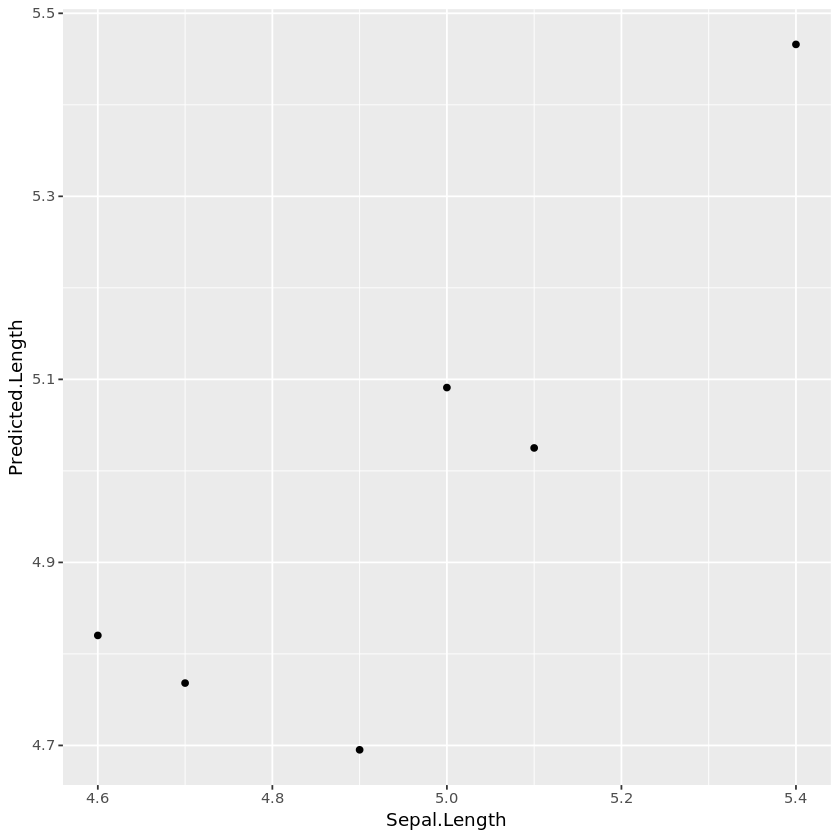

In [26]:
# Compare the predictions vs actual
ggplot(iris_test, aes(x=Sepal.Length, y=Predicted.Length)) + geom_point()

<h3>Deleting the endpoint</h3>

When you're done with the model, delete the endpoint to avoid incurring deployment costs:

In [ ]:
session$delete_endpoint(model_endpoint$endpoint)